# Question 2

In this question we will:

- Compute GLCM and LBP texture descriptors for a training dataset of texture images.
- Compute GLCM and LBP texture descriptors for a test dataset of texture images.
- Train a K-nearest-neighbours (KNN) classifier using the texture descriptors extracted from training images.
- Classify the texture descriptors from the test dataset using the KNN classifier.


# Step 1: Compute the texture descriptions for the training images.

For each training image, calculate a vector of GLCM features.  Which GLCM features and the set of displacements you choose to you use are up to you (note that displacements for `skimage.feature.graycomatrix()` need to be specified by distances and angles in **radians**).  Experiment with different combinations of displacements and features to obtain the best possible classification rate.  Use conservative choices to begin with until everything is working, then come back and experiemnt.  As described in the Topic 10 lecture notes, use `skimage.feature.graycomatrix()` and `skimage.feature.graycoprops()` to calculate GLCM features.  You'll probably want to use `normed=True` with `graycomatrix()`.  Your GLCM features should be stored as a 120-row array by m-element array, (m will depend on how many different features and displacements you used and whether or not you combine values for different displacements or not, e.g., by taking their mean).  

_Hint: Pay close attention to the format of the return values of  `graycomatrix()` and `graycoprops()`._

For each training image, calculate the rotationally invariant LBP features using `skiamge.feature.local_binary_pattern()`.  You can experiment with parameters `P` and `R` to get a good classification rate, but probably `P=8` and `R=1` are good enough.   For the `method` parameter, use `'uniform'` which gives you the rotationally-invariant uniform LBP variant we talked about in class.   Remember that `skiamge.feature.local_binary_pattern()` returns an "LBP Image", which is an image in which, when P=8, the pixel value is between 0 and 9, and corresponds to one of the ten possible pattern labels.  It's up to you to turn the "LBP Image" into a 10-bin histogram, which serves as the feature vector for that image (you can use `numpy.histogram()` for this but again remember to specify `bins` and `range` parameters, and that it returns two things, and you only need the first one). 

Addionally, calculate the LBP variance feature again using `skimage.feature.local_binary_pattern()` but use `method='var'` instead.  This is the VAR feature we saw in class.  Use the same P and R as before.  Build a 16-bin histogram of the resulting 'LBP-VAR' image; use `range=(0,7000)` with `numpy.hisotgram()` (this is not quite "correct", but it's good enough).  Concatenate these with the rotationally invariant LBP features so that you have a 26-element feature vector for each training image.   These should be stored as a 120-row, 26-column array (26 columns assuming P=8).

You can do this all in one loop which builds both feature arrays.

In [107]:
import os

import numpy as np
import seaborn as sns
from skimage import io
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.util import img_as_ubyte
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

## Feature Extraction

### GLCM Parameters

In [108]:
distances = [1]
angles_degrees = np.arange(0, 180, 45)
angles = np.radians(angles_degrees)
props = [
    'contrast',  # Measures the intensity contrast between a pixel and its neighbor over the whole image
    'dissimilarity',  # Measures the local intensity variation between a pixel and its neighbor over the whole image
    'homogeneity',  # Measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal
    'energy',  # Measures the uniformity of distribution of elements in the GLCM
    'correlation',  # Measures the linear dependency of gray levels between a pixel and its neighbor over the whole image
    'ASM'  # Measures the local homogeneity of an image
]
levels = 8  # Gray Levels

### LBP Parameters

In [109]:
P = 8  # Number of points in the circular neighborhood
R = 1  # Radius of circle
lbp_method = 'uniform'
n_bins_lbp = P + 2  # Number of bins in the histogram

### LBP-VAR Parameters

In [110]:
n_bins_var = 16  # Number of bins in the histogram
var_range = (0, 7000)  # Range of values in the LBP-VAR image

## Data Processing

In [111]:
def process_image(idx, filename, GLCM_features, LBP_features):
    # Read image
    image = io.imread(filename, as_gray=True)

    image = img_as_ubyte(image)  # Convert image to 8-bit (0-255)

    image_quantized = (image / 32).astype(np.uint8)  # Quantize image to 8 levels

    # Compute GLCM
    P_matrix = graycomatrix(image_quantized, distances=distances, angles=angles,
                            levels=levels, symmetric=True, normed=True)

    # Compute GLCM properties
    glcm_feature_vector = []
    for prop in props:
        prop_values = graycoprops(P_matrix, prop)
        glcm_feature_vector.extend(prop_values.flatten())  # Graycoprops returns a 2D array and we need a 1D array
    GLCM_features[idx, :] = glcm_feature_vector

    # Compute LBP features
    lbp_image = local_binary_pattern(image, P, R, method=lbp_method)
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_bins_lbp + 1), range=(0, n_bins_lbp))
    lbp_hist = lbp_hist.astype(float) / lbp_hist.sum()  # Normalize histogram

    # Compute LBP-VAR features
    lbp_var_image = local_binary_pattern(image, P, R, method='var')
    lbp_var_hist, _ = np.histogram(lbp_var_image.ravel(), bins=n_bins_var, range=var_range)
    lbp_var_hist = lbp_var_hist.astype(float) / lbp_var_hist.sum()  # Normalize histogram

    # Concatenate LBP and LBP-VAR histograms
    lbp_feature_vector = np.hstack((lbp_hist, lbp_var_hist))
    LBP_features[idx, :] = lbp_feature_vector

    return GLCM_features, LBP_features

In [112]:
m = len(props) * len(distances) * len(angles)  # Total GLCM features per image

### Training Data

In [113]:
data_dir = 'data/brodatztraining/'
files = os.listdir(data_dir)

In [114]:
train_image_paths = [data_dir + path for path in files]
n_train = len(train_image_paths)
GLCM_features_train = np.zeros((n_train, m))
LBP_features_train = np.zeros((n_train, n_bins_lbp + n_bins_var))

In [115]:
for idx, filename in enumerate(train_image_paths):
    GLCM_features, LBP_features = process_image(idx, filename, GLCM_features_train, LBP_features_train)

In [116]:
GLCM_features_train = np.array(GLCM_features_train)
LBP_features_train = np.array(LBP_features_train)

In [117]:
GLCM_features_train.shape, LBP_features_train.shape

((120, 24), (120, 26))

# Step 2: Compute Test Image Features

Compute the exact same features as you did in step 1 for each of the test images.  Store them in the same way (these arrays will just have more rows, specifically 320 rows, one for each testing sample). For GLCM you'll probably have trouble beating 65% classification rate.  For LBP you should be able to get 95% or better.

In [118]:
data_dir = 'data/brodatztesting/'
files = os.listdir(data_dir)

In [119]:
test_image_paths = [data_dir + path for path in files]
n_test = len(test_image_paths)
GLCM_features_test = np.zeros((n_test, m))
LBP_features_test = np.zeros((n_test, n_bins_lbp + n_bins_var))

In [120]:
# Load images
for idx, filename in enumerate(test_image_paths):
    GLCM_features, LBP_features = process_image(idx, filename, GLCM_features_test, LBP_features_test)

In [121]:
GLCM_features_test = np.array(GLCM_features_test)
LBP_features_test = np.array(LBP_features_test)

In [122]:
GLCM_features_test.shape, LBP_features_test.shape

((320, 24), (320, 26))

# Step 3: Generate Label Arrays for the Training and Testing Data

Use labels 1 for the first class, label 2 for the second class, etc.   This should be easy to do since the filenames are ordered in blocks of 15 or 40 images of each class for training and testing respectively.

In [123]:
train_labels = np.array([i // 15 + 1 for i in range(n_train)])
test_labels = np.array([i // 40 + 1 for i in range(n_test)])

# Step 4:  Train an KNN classifier.  

Train an KNN  classifier using your GLCM features.  Train another one using your LBP features.



In [124]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

## LBP Features

In [125]:
knn = KNeighborsClassifier()

# Perform the grid search
grid_search = GridSearchCV(knn, param_grid, cv=LeaveOneOut(), scoring='accuracy')
grid_search.fit(LBP_features_train, train_labels)

knn_lbp = grid_search.best_estimator_
knn_lbp.fit(LBP_features_train, train_labels)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

## GLCM Features

In [126]:
knn = KNeighborsClassifier()

# Perform the grid search
grid_search = GridSearchCV(knn, param_grid, cv=LeaveOneOut(), scoring='accuracy')
grid_search.fit(GLCM_features_train, train_labels)

knn_glcm = grid_search.best_estimator_
knn_glcm.fit(GLCM_features_train, train_labels)

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

# Step 5:  Predict the classes of the test images

Predict the classes of the test images using both classifiers.

In [127]:
lbp_predictions = knn_lbp.predict(LBP_features_test)

In [128]:
glcm_predictions = knn_glcm.predict(GLCM_features_test)

# Step 6:  Display Results

Display results as in the final step of Question 1.  For each classifier display the image filenames that were incorrectly classified, the confisuion matrix, and the classification rate.  





In [129]:
def display_results(predictions, test_labels, test_image_paths):
    misclassified_images = []
    for idx, (pred, label) in enumerate(zip(predictions, test_labels)):
        if pred != label:
            misclassified_images.append((test_image_paths[idx], pred, label))

    print('\tMisclassified Images:')
    for image in misclassified_images:
        print(f"\t\t{image[0]}: Predicted {image[1]}, Actual {image[2]}")

    # Display confusion matrix
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.arange(1, 9), yticklabels=np.arange(1, 9))

    classification_rate = np.mean(predictions == test_labels)
    print(f'\tClassification Rate: {classification_rate}')

LBP Features:
	Misclassified Images:
		data/brodatztesting/patch-210674.png: Predicted 1, Actual 2
		data/brodatztesting/patch-248638.png: Predicted 1, Actual 2
	Classification Rate: 0.99375


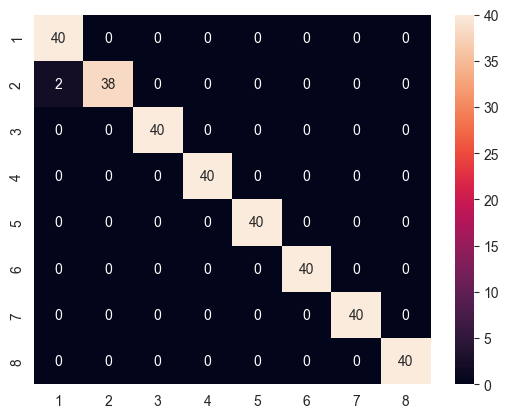

In [130]:
print('LBP Features:')
display_results(lbp_predictions, test_labels, test_image_paths)

GLCM Features:
	Misclassified Images:
		data/brodatztesting/patch-100320.png: Predicted 7, Actual 1
		data/brodatztesting/patch-116291.png: Predicted 3, Actual 1
		data/brodatztesting/patch-119480.png: Predicted 7, Actual 1
		data/brodatztesting/patch-120541.png: Predicted 7, Actual 1
		data/brodatztesting/patch-120552.png: Predicted 7, Actual 1
		data/brodatztesting/patch-123647.png: Predicted 7, Actual 1
		data/brodatztesting/patch-124729.png: Predicted 7, Actual 1
		data/brodatztesting/patch-128641.png: Predicted 7, Actual 1
		data/brodatztesting/patch-129875.png: Predicted 7, Actual 1
		data/brodatztesting/patch-130899.png: Predicted 7, Actual 1
		data/brodatztesting/patch-131612.png: Predicted 3, Actual 1
		data/brodatztesting/patch-131973.png: Predicted 3, Actual 1
		data/brodatztesting/patch-135528.png: Predicted 7, Actual 1
		data/brodatztesting/patch-136304.png: Predicted 7, Actual 1
		data/brodatztesting/patch-139159.png: Predicted 7, Actual 1
		data/brodatztesting/patch-1402

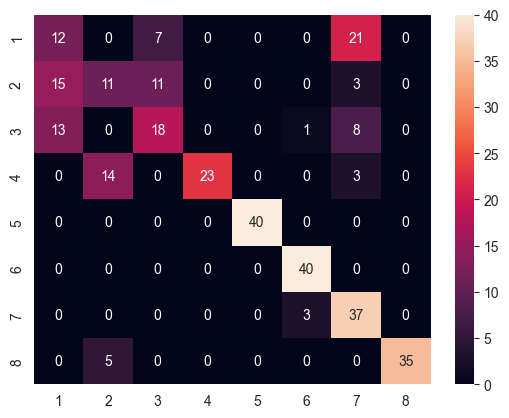

In [131]:
print('GLCM Features:')
display_results(glcm_predictions, test_labels, test_image_paths)

# Step 7: Reflections

Answer the following questions right here in this block:

- Discuss the performance difference of the two different texture features.  Hypothesize reasons for observed differences.
	
	The difference in performance can be due to difference in the capacity of capturing features. The co-occurrence matrix captures the spatial relationship between pixels, which can be useful for textures with repetitive patterns, and we can see that in the confusion matrix, but when it came to the coarse textures it didn't perform well. On the other hand, the LBP features allow to capture more complex patterns, which allowed the classifier to perform better on the test images.
	
    A hypothesis for the observed difference is that the LBP features are more robust to the differences in the textures, as they capture more complex patterns. The GLCM features might not be able to capture the complexity of the textures, which can result in a lower classification rate. Also, the pattern is not as clear in most of the images, so creating a co-occurrence matrix might not be as useful as using LBP features.

- For each of your two classifiers, discuss the misclassified images.  Were there any classes that were particularly difficult to distinguish?  Do the misclassified images (over all classes) have anything in common that would cause them to be misclassified?  If so what do they ahve in common, and why do you think it is confusing the classifier?

	The LBP classifier only had trouble with 2 images of the second class, where they were predicted as being part of the first. This is because both of the textures look very similar to the naked eye and have similar patterns, which can confuse the classifier. But, overall, it performed very well.
	
    Now, the GLCM classifier had trouble with most of the images in the first 3 classes. The images have in common that the patterns present very drastic changes on the texture, which can be hard to capture using the co-occurrence matrix or, simply, the distance between the pixels is too great, which can result in a lower classification rate. That said, my best guess on why it is confusing is that the co-occurrence matrix of the first 3 classes is very similar.